In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator



## importing data and pre processing 

In [5]:
# path 
train_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\train"
test_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\test"

#class and sizes of images and bacthes 
num_classes = 2
img_rows, img_cols = 224, 224
batch_size = 16

## data augmentation

# what we want 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

# applying on the data 
train_generator = train_datagen.flow_from_directory(
        train_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        test_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2002 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## model 

In [45]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_96 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_97 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 32)    

## call back, checkponts  and training 

In [46]:

from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\model_01.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 2000
nb_validation_samples = 1000
epochs = 25


history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

import pickle 
pickle_out = open("checkpoint.pickle" , 'wb')
pickle.dump (checkpoint , pickle_out)
pickle_out.close()

Epoch 1/25
 71/125 [================>.............] - ETA: 3:03 - loss: 1.0689 - accuracy: 0.5178

KeyboardInterrupt: 

## confusion matrix 

Found 1000 images belonging to 2 classes.
Confusion Matrix
[[ 87 413]
 [ 43 457]]
Classification Report
              precision    recall  f1-score   support

         cat       0.67      0.17      0.28       500
         dog       0.53      0.91      0.67       500

    accuracy                           0.54      1000
   macro avg       0.60      0.54      0.47      1000
weighted avg       0.60      0.54      0.47      1000



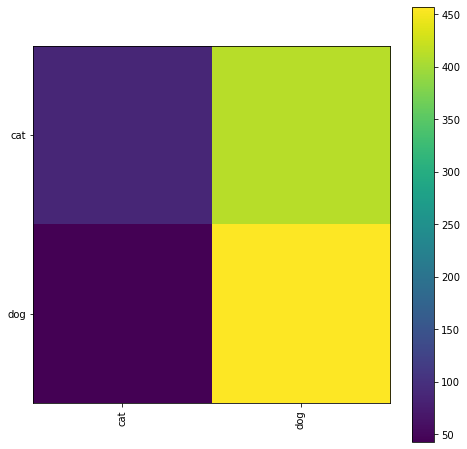

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 

# loading model
pickle_in = open("checkpoint.pickle" , 'rb')
model = pickle.load (pickle_in)

img_row, img_height, img_depth = 32,32,3
model = load_model('F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\model_01.h5')

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        test_data,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#nb_train_samples = 2000
#nb_validation_samples = 1000


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

## test

# loading model and getting class labels 

In [6]:
from keras.models import load_model
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 


pickle_in = open("checkpoint.pickle" , 'rb')
model = pickle.load (pickle_in)

img_row, img_height, img_depth = 32,32,3
model = load_model('F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\model_01.h5')


## getting our class labels 

validation_generator = validation_datagen.flow_from_directory(
        test_data,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)



Found 1000 images belonging to 2 classes.
{0: 'cat', 1: 'dog'}


In [7]:

from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images

test_data = "F:\\pneumonia\\[FreeTutorials.Us] Udemy - Deep Learning Computer Vision\\10. Data Augmentation Build a Cats vs Dogs Classifier\\2.1 datasets.zip\\datasets\\catsvsdogs\\images\\test\\"


for i in range(0, 10):
    path = test_data 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()